In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

In [5]:
BATCH_SIZE = 32
IMG_HEIGHT = 300
IMG_WIDTH = 300
CHANNELS = 3
EPOCHS = 15
BASE_DIR = "Plant Village"

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(BASE_DIR, "train"),
    seed=123,
    shuffle=True,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(BASE_DIR, "val"),
    seed=123,
    shuffle=True,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(BASE_DIR, "test"),
    seed=123,
    shuffle=True,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 3595 files belonging to 6 classes.
Found 768 files belonging to 6 classes.
Found 776 files belonging to 6 classes.


In [7]:
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['CCI_Caterpillars', 'CCI_Leaflets', 'Healthy_Leaves', 'WCLWD_DryingofLeaflets', 'WCLWD_Flaccidity', 'WCLWD_Yellowing']


In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),  # Random flips
    RandomRotation(0.2),                    # Random rotations up to 20%
    RandomZoom(0.2),                       # Random zoom up to 20%
    RandomContrast(0.2),                   # Random contrast adjustments
])

In [10]:
model = tf.keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    data_augmentation,  # Apply augmentation during training
    Rescaling(1./255),  # Normalize pixel values to [0, 1]
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
    Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(len(class_names), activation='softmax')  # Output layer for 6 classes
])

In [11]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=3,               # Stop after 3 epochs of no improvement
    restore_best_weights=True # Restore weights from the best epoch
)

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.3598 - loss: 2.7676 - val_accuracy: 0.8190 - val_loss: 0.9086
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.7896 - loss: 0.9466 - val_accuracy: 0.8854 - val_loss: 0.6488
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.8442 - loss: 0.7272 - val_accuracy: 0.8724 - val_loss: 0.6323
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.8631 - loss: 0.6905 - val_accuracy: 0.8568 - val_loss: 0.6383
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.8792 - loss: 0.6201 - val_accuracy: 0.9062 - val_loss: 0.5276
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.8694 - loss: 0.6764 - val_accuracy: 0.9167 - val_loss: 0.4609
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.8758 - loss: 0.6042 - val_accuracy: 0.8698 - val_loss: 0.5673
Epoch 8/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.8758 - loss: 0.6152 - val_accu

In [14]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.9266 - loss: 0.4620 
Test Accuracy: 0.9433, Test Loss: 0.4248


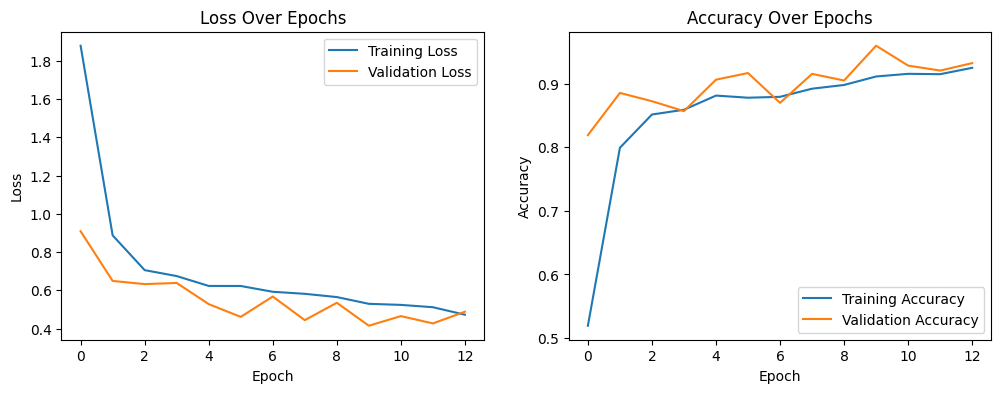

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
def predict(model, img):
    img_array = tf.expand_dims(img, 0)  # Add batch dimension
    predictions = model.predict(img_array)
    predicted_class = class_names[tf.argmax(predictions[0])]
    confidence = round(100 * tf.reduce_max(predictions[0]), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


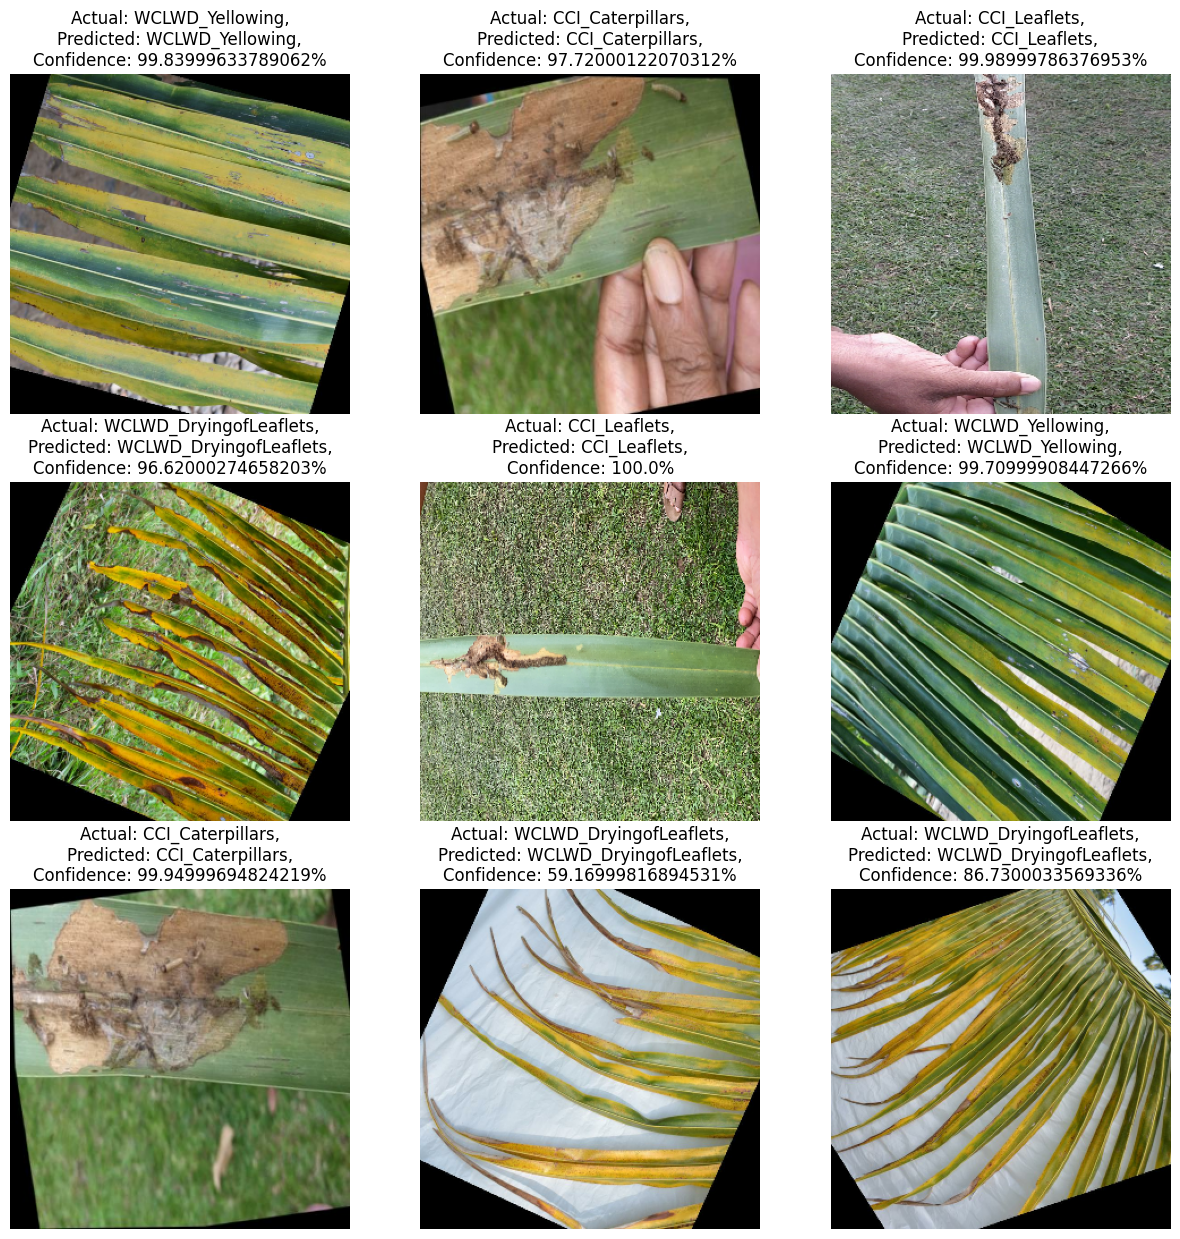

In [18]:
tf.experimental.numpy.experimental_enable_numpy_behavior()
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(min(9, len(images))):  # Handle batches with fewer than 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class},\nConfidence: {confidence}%")
        plt.axis("off")
plt.show()

In [19]:
model.save('trained_model.keras')
print("Model saved as 'trained_model.keras'")

Model saved as 'trained_model.keras'
